# Sprint
## 深層学習スクラッチ 畳み込みニューラルネットワーク1

## 1.このSprintについて

### Sprintの目的
スクラッチを通してCNNの基礎を理解する

### どのように学ぶか
スクラッチで1次元用畳み込みニューラルネットワークを実装した後、学習と検証を行なっていきます。

## 2.1次元の畳み込みニューラルネットワークスクラッチ

**畳み込みニューラルネットワーク（CNN）**のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


このSprintでは1次元の**畳み込み層**を作成し、畳み込みの基礎を理解することを目指します。次のSprintでは2次元畳み込み層とプーリング層を作成することで、一般的に画像に対して利用されるCNNを完成させます。


クラスの名前はScratch1dCNNClassifierとしてください。クラスの構造などは前のSprintで作成したScratchDeepNeuralNetrowkClassifierを参考にしてください。


### 1次元畳み込み層とは
CNNでは画像に対しての2次元畳み込み層が定番ですが、ここでは理解しやすくするためにまずは1次元畳み込み層を実装します。1次元畳み込みは実用上は自然言語や波形データなどの**系列データ**で使われることが多いです。


畳み込みは任意の次元に対して考えることができ、立体データに対しての3次元畳み込みまではフレームワークで一般的に用意されています。


### データセットの用意
検証には引き続きMNISTデータセットを使用します。1次元畳み込みでは全結合のニューラルネットワークと同様に平滑化されたものを入力します。

### 【問題1】
#### チャンネル数を1に限定した1次元畳み込み層クラスの作成
チャンネル数を1に限定した1次元畳み込み層のクラスSimpleConv1dを作成してください。基本構造は前のSprintで作成した全結合層のFCクラスと同じになります。なお、重みの初期化に関するクラスは必要に応じて作り変えてください。Xavierの初期値などを使う点は全結合層と同様です。


ここでは**パディング**は考えず、**ストライド**も1に固定します。また、複数のデータを同時に処理することも考えなくて良く、バッチサイズは1のみに対応してください。この部分の拡張はアドバンス課題とします。


フォワードプロパゲーションの数式は以下のようになります。

$$
a_i = \sum_{s=0}^{F-1}x_{(i+s)}w_s+b
$$

$a_i$ : 出力される配列のi番目の値


$F$ : フィルタのサイズ


$x_{(i+s)}$ : 入力の配列の(i+s)番目の値


$w_s$ : 重みの配列のs番目の値


$b$ : バイアス項


全てスカラーです。


次に更新式です。ここがAdaGradなどに置き換えられる点は全結合層と同様です。

$$
w_s^{\prime} = w_s - \alpha \frac{\partial L}{\partial w_s} \\
b^{\prime} = b - \alpha \frac{\partial L}{\partial b}
$$

$\alpha$ : 学習率


$\frac{\partial L}{\partial w_s}$ : $w_s$に関する損失$L$の勾配


$\frac{\partial L}{\partial b}$ : $b$に関する損失$L$の勾配


勾配$\frac{\partial L}{\partial w_s}$や$\frac{\partial L}{\partial b}$を求めるためのバックプロパゲーションの数式が以下です。

$$
\frac{\partial L}{\partial w_s} = \sum_{i=0}^{N_{out}-1} \frac{\partial L}{\partial a_i}x_{(i+s)}\\
\frac{\partial L}{\partial b} = \sum_{i=0}^{N_{out}-1} \frac{\partial L}{\partial a_i}
$$

$\frac{\partial L}{\partial a_i}$ : 勾配の配列のi番目の値


$N_{out}$ : 出力のサイズ


前の層に流す誤差の数式は以下です。

$$
\frac{\partial L}{\partial x_j} = \sum_{s=0}^{F-1} \frac{\partial L}{\partial a_{(j-s)}}w_s
$$

$\frac{\partial L}{\partial x_j}$ : 前の層に流す誤差の配列のj番目の値


ただし、$j−s<0$または$j−s>N_{out}−1$のとき$\frac{\partial L}{\partial a_{(j-s)}}=0$です。


全結合層との大きな違いは、重みが複数の特徴量に対して共有されていることです。この場合は共有されている分の誤差を全て足すことで勾配を求めます。計算グラフ上での分岐はバックプロパゲーションの際に誤差の足し算をすれば良いことになります。

In [1]:
# import modules
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [2]:
class SimpleConv1d:
    """
    チャンネル数を1に限定した1次元畳み込み層
    (パディングなし　ストライド1)
    """
    def __init__(self, filter_size, input_size, initializer, optimizer):
        self.optimizer = optimizer
        self.filter_size = filter_size
        self.input_size = input_size
        self.output_size = calc_output_size(input_size, 0, filter_size, 1)
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(filter_size)
        self.B = initializer.B()

    def forward(self, X):
        """
        フォワード
        """
        self.X_ = X

        A = np.zeros(self.output_size)
        for i in range(self.output_size):
            A[i] = np.sum(X[i:i+self.filter_size]*self.W) + self.B

        return A

    def backward(self, dA):
        """
        バックワード
        """
        # 更新
        dX = self.optimizer.update(self, dA)

        return dX

In [3]:
class SGDConv:
    """
    勾配降下法（畳み込み）
    """
    def __init__(self, lr):
        self.lr = lr

    def update(self, layer, dA):
        """
        ある層の重みやバイアスの更新
        """
        # dA (out_size,)
        # dB (1,)
        dB = np.sum(dA, axis=0)

        # dW (filter_size,)
        dW = np.zeros(layer.filter_size)
        for s in range(layer.filter_size):
            dW[s] = np.matmul(layer.X_[s:s+layer.output_size].T, dA)
        
        # dX (input_size,)
        W_tile = np.zeros((layer.output_size, layer.input_size))
        for s in range(layer.output_size):
            W_tile[s, s:s+layer.filter_size] = layer.W
        dX = np.matmul(dA, W_tile)

        layer.B = layer.B - self.lr*dB
        layer.W = layer.W - self.lr*dW

        return dX

### 【問題2】
#### 1次元畳み込み後の出力サイズの計算
畳み込みを行うと特徴量の数が変化します。どのように変化するかは以下の数式から求められます。パディングやストライドも含めています。この計算を行う関数を作成してください。

$$
N_{out} =  \frac{N_{in}+2P-F}{S} + 1\\
$$

$N_{out}$ : 出力のサイズ（特徴量の数）


$N_{in}$ : 入力のサイズ（特徴量の数）


$P$ : ある方向へのパディングの数


$F$ : フィルタのサイズ


$S$ : ストライドのサイズ

In [4]:
def calc_output_size(input_size, padding, filter_size, stride_size):
    n_out = ((input_size+2*padding-filter_size) / stride_size) + 1
    return int(n_out)

### 【問題3】
#### 小さな配列での1次元畳み込み層の実験
次に示す小さな配列でフォワードプロパゲーションとバックプロパゲーションが正しく行えているか確認してください。


入力x、重みw、バイアスbを次のようにします。

```python
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])
```

フォワードプロパゲーションをすると出力は次のようになります。

```python
a = np.array([35, 50])
```

次にバックプロパゲーションを考えます。誤差は次のようであったとします。

```python
delta_a = np.array([10, 20])
```

バックプロパゲーションをすると次のような値になります。

``` python
delta_b = np.array([30])
delta_w = np.array([50, 80, 110])
delta_x = np.array([30, 110, 170, 140])
```

In [5]:
# forward
x = np.array([1, 2, 3, 4])
w = np.array([3, 5, 7])
b = np.array([1])

a = np.zeros((x.shape[0]-w.shape[0]+1,))
for i in range(a.shape[0]):
    a[i] = np.sum(x[i:i+w.shape[0]]*w) + b

print(a)
## a = np.array([35, 50])

[35. 50.]


In [6]:
# backward
delta_a = np.array([10, 20])

delta_b = np.sum(delta_a)
delta_w = np.zeros(w.shape[0])
for s in range(delta_w.shape[0]):
    delta_w[s] = np.dot(x[s:s+delta_a.shape[0]], delta_a)

delta_x = np.zeros(x.shape[0])
delta_a_padding = np.pad(delta_a, (w.shape[0]-1, max((0, x.shape[0]-delta_a.shape[0]))), mode='constant')
for s in range(delta_x.shape[0]):
    delta_x[s] = np.sum(delta_a_padding[s:s+w.shape[0]]*w[::-1])

print(delta_b)
## delta_b = np.array([30])
print(delta_w)
## delta_w = np.array([50, 80, 110])
print(delta_x)
## delta_x = np.array([30, 110, 170, 140])

30
[ 50.  80. 110.]
[ 30. 110. 170. 140.]


### 実装上の工夫
畳み込みを実装する場合は、まずはfor文を重ねていく形で構いません。しかし、できるだけ計算は効率化させたいため、以下の式を一度に計算する方法を考えることにします。

$$
a_i = \sum_{s=0}^{F-1}x_{(i+s)}w_s+b
$$

バイアス項は単純な足し算のため、重みの部分を見ます。

$$
\sum_{s=0}^{F-1}x_{(i+s)}w_s
$$

これは、xの一部を取り出した配列とwの配列の内積です。具体的な状況を考えると、以下のようなコードで計算できます。この例では流れを分かりやすくするために、各要素同士でアダマール積を計算してから合計を計算しています。これは結果的に内積と同様です。

```python
x = np.array([1, 2, 3, 4])
w = np.array([3, 5, 7])
a = np.empty((2, 3))
indexes0 = np.array([0, 1, 2]).astype(np.int)
indexes1 = np.array([1, 2, 3]).astype(np.int)
a[0] = x[indexes0]*w # x[indexes0]は([1, 2, 3])である
a[1] = x[indexes1]*w # x[indexes1]は([2, 3, 4])である
a = a.sum(axis=1)
````

ndarrayは配列を使ったインデックス指定ができることを利用した方法です。


また、二次元配列を使えば一次元配列から二次元配列が取り出せます。

```python
x = np.array([1, 2, 3, 4])
indexes = np.array([[0, 1, 2], [1, 2, 3]]).astype(np.int)
print(x[indexes]) # ([[1, 2, 3], [2, 3, 4]])
```

このこととブロードキャストなどをうまく組み合わせることで、一度にまとめて計算することも可能です。


畳み込みの計算方法に正解はないので、自分なりに効率化していってください。


**《参考》**


以下のページのInteger array indexingの部分がこの方法についての記述です。


[Indexing — NumPy v1.17 Manual](https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html)

### 【問題4】
#### チャンネル数を限定しない1次元畳み込み層クラスの作成
チャンネル数を1に限定しない1次元畳み込み層のクラスConv1dを作成してください。


例えば以下のようなx, w, bがあった場合は、

```python
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) # shape(2, 4)で、（入力チャンネル数、特徴量数）である。
w = np.ones((3, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
b = np.array([1, 2, 3]) # （出力チャンネル数）
```

出力は次のようになります。

```python
a = np.array([[16, 22], [17, 23], [18, 24]]) # shape(3, 2)で、（出力チャンネル数、入力チャンネル数）である。
```

入力が2チャンネル、出力が3チャンネルの例です。計算グラフを書いた上で、バックプロパゲーションも手計算で考えてみましょう。計算グラフの中には和と積しか登場しないので、微分を新たに考える必要はありません。


**《補足》**


チャンネル数を加える場合、配列をどういう順番にするかという問題があります。**(バッチサイズ、チャンネル数、特徴量数)**または**(バッチサイズ、特徴量数、チャンネル数)**が一般的で、ライブラリによって順番は異なっています。（切り替えて使用できるものもあります）


今回のスクラッチでは自身の実装上どちらが効率的かを考えて選んでください。上記の例ではバッチサイズは考えておらず、**(チャンネル数、特徴量数)**です。

In [7]:
class Conv1d:
    """
    チャンネル数を限定しない1次元畳み込み層
    """
    def __init__(self, optimizer, input_channel, output_channel, input_size, filter_size, padding=0, stride=1):
        self.optimizer = optimizer
        self.input_channel = input_channel
        self.output_channel = output_channel        
        self.input_size = input_size
        self.output_size = calc_output_size(input_size, padding, filter_size, stride)
        self.filter_size = filter_size
        # 初期化(He)
        self.W = np.sqrt(2/output_channel) * np.random.randn(output_channel, input_channel, filter_size)
        self.B = np.zeros(output_channel)
        # kwargs
        self.padding = padding
        self.stride = stride

    def forward(self, X):
        """
        フォワード
        """
        # X (batch_size, input_channel, input_size)
        # padding
        X = np.pad(X, ((0, 0), (0, 0), (self.padding, self.padding)), mode='constant')
        
        self.batch_size = X.shape[0]

        # 逆伝搬用
        self.X_ = X

        A = np.zeros((self.batch_size, self.output_channel, self.output_size))
        for i in range(self.output_size):
            # Stride
            start_index = i*self.stride
            # X * W
            # X (batch_size,     1(->output_channel), input_channel, filter_size)
            # W ((->batch_size,) output_channel,      input_channel, filter_size)
            XW = X[:, np.newaxis, :, start_index:(start_index+self.filter_size)] * self.W
            # A (batch_size, output_channel, output_size)
            A[:, :, i] = np.sum(XW, axis=(2, 3)) + self.B

        return A

    def backward(self, dA):
        """
        バックワード
        """
        # 更新
        dX = self.optimizer.update(self, dA)

        return dX

**以下問題5, 6, 7についても`Conv1d`クラスを編集する。**

### 【問題5】
#### （アドバンス課題）パディングの実装
畳み込み層にパディングの機能を加えてください。1次元配列の場合、前後にn個特徴量を増やせるようにしてください。


最も単純なパディングは全て0で埋める ゼロパディング であり、CNNでは一般的です。他に端の値を繰り返す方法などもあります。


フレームワークによっては、元の入力のサイズを保つようにという指定をすることができます。この機能も持たせておくと便利です。なお、NumPyにはパディングの関数が存在します。


[numpy.pad — NumPy v1.17 Manual](https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html)

### 【問題6】
#### （アドバンス課題）ミニバッチへの対応
ここまでの課題はバッチサイズ1で良いとしてきました。しかし、実際は全結合層同様にミニバッチ学習が行われます。Conv1dクラスを複数のデータが同時に計算できるように変更してください。

### 【問題7】
#### （アドバンス課題）任意のストライド数
ストライドは1限定の実装をしてきましたが、任意のストライド数に対応できるようにしてください。

問5,6,7の拡張に対応したバックプロパゲーションを実装する。

In [8]:
class SGDConvMulti:
    """
    勾配降下法（畳み込み）

    """
    def __init__(self, lr):
        self.lr = lr

    def update(self, layer, dA):
        """
        ある層の重みやバイアスの更新
        """    
        # dA (batch_size, output_channel, output_size)
        # dB (output_channel)
        dB = np.sum(dA, axis=(0, 2))

        # dW (output_channel, input_channel, filter_size)
        dW = np.zeros((layer.output_channel, layer.input_channel, layer.filter_size))
        for i in range(layer.filter_size):
            # layer.X_ (batch_sizem, input_channel, input_size)
            # XdA (batch_size, input_channel, output_channel)
            XdA = np.matmul(
                layer.X_[:, :, i:i+layer.stride*layer.output_size:layer.stride],
                dA.transpose(0, 2, 1)
            )
        
        # dX (batch_size, input_channel, input_size)
        # W (output_channel, input_channel, filter_size)
        W_tile = np.zeros((layer.input_channel,
                           layer.output_channel,
                           layer.output_size,
                           layer.input_size+2*layer.padding))
        for s in range(layer.output_size):
            i = s*layer.stride
            W_tile[:, :, s, i:i+layer.filter_size] = layer.W.transpose(1, 0, 2)

        # dAW (batch_size, input_channel, output_channel, output_size, input_size+2*padding)
        dAW = dA[:, np.newaxis, :, :, np.newaxis]*W_tile[np.newaxis, ...]
        dX = np.sum(dAW, axis=(2, 3))

        if layer.padding > 0: dX = dX[:, :, layer.padding:-layer.padding]

        layer.B = layer.B - self.lr*dB
        layer.W = layer.W - self.lr*dW

        return dX

### 【問題8】
#### 学習と推定
これまで使ってきたニューラルネットワークの全結合層の一部をConv1dに置き換えてMNISTを学習・推定し、Accuracyを計算してください。


出力層だけは全結合層をそのまま使ってください。ただし、チャンネルが複数ある状態では全結合層への入力は行えません。その段階でのチャンネルは1になるようにするか、**平滑化**を行なってください。


画像に対しての1次元畳み込みは実用上は行わないことのため、精度は問いません。

活性化関数: ReLU, 最適化: AdaGradに限定する。

In [9]:
class ScratchConvolutionalNeuralNetworkClassifier:
    """
    多層ニューラルネットワーク分類器

    Parameters
    ----------
    alpha : float
        学習率
    sigma : float
        ガウス分布の標準偏差
    batch_size : int
        バッチのサイズ
    epoch : int
        エポック数

    Attributes
    ----------
    self.loss : list
        交差エントロピー誤差（訓練データ）
    self.val_loss : list
        交差エントロピー誤差（バリデーションデータ)
    """
    def __init__(self, layers, batch_size=20, epoch=1, verbose=True):
        self.layers = layers
        self.batch_size = batch_size
        self.epoch = epoch
        self.verbose = verbose
        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, n_classes) (one-hot)
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, n_classes) (one-hot)
            検証データの正解値
        """
        ## loss list
        self.loss = []
        self.val_loss = []

        if self.verbose:
            #verboseをTrueにした際は学習過程などを出力する
            print('start learning')

        start_time = time.time()

        # learning
        for e in range(self.epoch):
            print(f'start epoch {e+1}')

            ## mini_batch
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size, seed=e)

            ## loss list
            self.loss.append([])

            for i, (mini_X_train, mini_y_train) in enumerate(get_mini_batch):                
                ## forward propagation
                Z = None
                for layer in self.layers:
                    ## calc A
                    if Z is None:
                        Z = layer.forward(mini_X_train)
                    else:
                        Z = layer.forward(Z)
                            
                ## update weight, bias
                ## append loss
                gradient = None
                for layer in self.layers[::-1]:
                    if gradient is None:
                        ## backward
                        gradient = layer.backward(Z, mini_y_train)
                        ## loss
                        self.loss[e].append(layer.loss)
                    else:
                        ## backward
                        gradient = layer.backward(gradient)

                ## print progress
                if self.verbose:
                    print(f'\r{i+1}/{len(get_mini_batch)} loop finished', end='')

            ## validation
            if (X_val is not None) and (y_val is not None):
                ### prediction
                Z_val = None
                for layer in self.layers:
                    if Z_val is None:
                        Z_val = layer.forward(X_val)
                    else:
                        Z_val = layer.forward(Z_val)
                ### append loss
                self.val_loss.append(self.layers[-1].calc_cross_entropy_loss(y_val, Z_val))

            if self.verbose:
                print(' : Complete!!')
            if y_val is not None:
                print(f'epoch {e+1} valid loss: {self.val_loss[-1]}')

        end_time = time.time()
        elapsed_time = end_time - start_time

        # output loss
        print(f'last train loss: {self.loss[-1][-1]}')

        print(f'Done! elapsed time: {elapsed_time:.5f}s')

    def predict_proba(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, n_classes)
            推定結果
        """
        ## forward propagation
        Z = None
        for layer in self.layers:
            if Z is None:
                Z = layer.forward(X)
            else:
                Z = layer.forward(Z)    
            
        return Z

    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples,)
            推定結果
        """
        ## forward propagation
        Z = self.predict_proba(X)    
            
        return np.argmax(Z, axis=1)

In [10]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス

    Attribute
    ---------
    self.W : ndarray(n_nodes1, n_nodes2)
      重み
    self.B : ndarray(n_node2,)
      バイアス
    self.H : float
      前イテレーションまでの勾配の二乗和
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        self.HW = np.zeros(self.W.shape)
        self.HB = np.zeros(self.B.shape)
        pass

    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        if X.ndim > 2:
            X = X.reshape(X.shape[0], -1)

        self.X_ = X

        A = X@self.W + self.B

        return A

    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """

        # 更新
        dZ = self.optimizer.update(self, dA)

        return dZ

class Softmax:
    """
    ソフトマックス関数

    Attribute
    ----------
    self.loss
        出力の交差エントロピー誤差
    """
    def forward(self, A):
        Z = np.exp(A) / np.sum(np.exp(A), axis=1).reshape(-1, 1)
        
        return Z

    def backward(self, Z, Y):
        dA = Z - Y
        self.loss = self.calc_cross_entropy_loss(Y, Z)

        return dA
    
    def calc_cross_entropy_loss(self, y_true, y_pred):
        n_samples = y_true.shape[0]

        cross_entropy_loss = (-1 * (np.sum(y_true*np.log(y_pred)))) / n_samples
 
        return cross_entropy_loss

class ReLU:
    """
    ReLU関数

    Attribute
    ----------
    self.A
        活性化関数の入力
    """
    def forward(self, A):
        self.pos = A > 0
        Z = self.pos*A
        return Z
    
    def backward(self, dZ):
        if dZ.shape == self.pos.shape:
            dA = self.pos*dZ
        else:
            dA = self.pos*dZ[:, np.newaxis, :]

        return dA

class HeInitializer:
    """
    Heの初期値
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数

    Attributes
    ----------
    self.sigma
      ガウス分布の標準偏差
    """
    def __init__(self, n_nodes1):
        self.sigma = np.sqrt(2/n_nodes1)
    
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
          重み
        """
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        
        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
          バイアス
        """
        B = np.zeros((n_nodes2,))

        return B

class SGD:
    """
    勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr

    def update(self, layer, dA):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        dB = np.sum(dA, axis=0)
        dW = layer.X_.T@dA
        dZ = dA@layer.W.T

        layer.B = layer.B - self.lr*dB
        layer.W = layer.W - self.lr*dW

        return dZ

In [11]:
# Sprint9から拝借
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [12]:
# データのロード
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(-1, 784).astype(np.float)[:, np.newaxis]
X_test = X_test.reshape(-1, 784).astype(np.float)[:, np.newaxis]
X_train /= 255
X_test /= 255
# one-hot-encoding
enc = OneHotEncoder(handle_unknown="ignore", sparse=False)
y_train = enc.fit_transform(y_train[:, np.newaxis])
y_test = enc.fit_transform(y_test[:, np.newaxis])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(48000, 1, 784) (48000, 10)
(12000, 1, 784) (12000, 10)
(10000, 1, 784) (10000, 10)


In [13]:
# 学習
lr = 0.01
conv = Conv1d(optimizer=SGDConvMulti(lr=lr),
              input_channel=1,
              output_channel=1,
              input_size=784,
              filter_size=5)
flatten_size = conv.output_size*conv.output_channel
layers = [
    conv,
    ReLU(),
    FC(n_nodes1=flatten_size,
       n_nodes2=100,
       initializer=HeInitializer(20),
       optimizer=SGD(lr=lr)),
    ReLU(),
    FC(n_nodes1=100,
       n_nodes2=10,
       initializer=HeInitializer(20),
       optimizer=SGD(lr=lr)),
    Softmax()
]
params = {
    'batch_size':200,
    'epoch':5,
    'verbose':True,
}
scratchCNN = ScratchConvolutionalNeuralNetworkClassifier(layers=layers, **params)
scratchCNN.fit(X_train, y_train, X_val, y_val)

start learning
start epoch 1
240/240 loop finished : Complete!!
epoch 1 valid loss: 2.3020605733065924
start epoch 2
240/240 loop finished : Complete!!
epoch 2 valid loss: 2.306456953072067
start epoch 3
240/240 loop finished : Complete!!
epoch 3 valid loss: 2.3082625527333573
start epoch 4
240/240 loop finished : Complete!!
epoch 4 valid loss: 2.3043634569907585
start epoch 5
240/240 loop finished : Complete!!
epoch 5 valid loss: 2.3046501727887043
last train loss: 2.3029576461637027
Done! elapsed time: 793.47634s


In [14]:
from sklearn.metrics import accuracy_score
y_pred = scratchCNN.predict(X_test)
print(y_pred)
print(np.argmax(y_test, axis=1))
print(accuracy_score(np.argmax(y_test, axis=1), y_pred))

[1 1 1 ... 1 1 1]
[7 2 1 ... 4 5 6]
0.1135


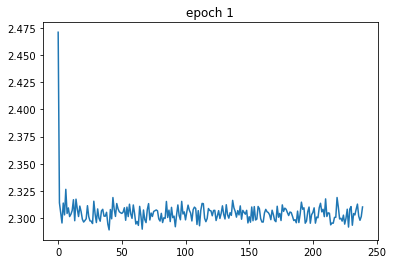

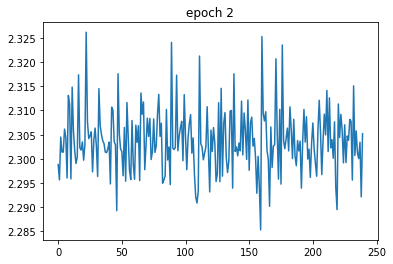

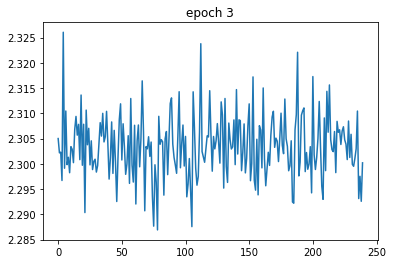

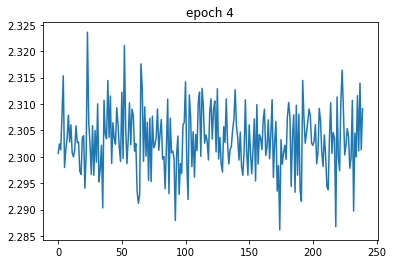

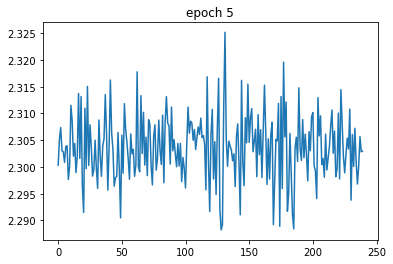

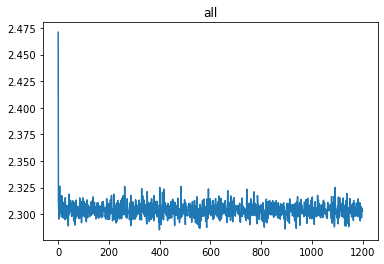

In [28]:
for i in range(5):
    plt.plot(scratchCNN.loss[i])
    plt.title(f'epoch {i+1}')
    plt.show()
plt.plot(sum(scratchCNN.loss, []))
plt.title('all')
plt.show()

エポック1序盤では損失が低下しているが、損失が2.3付近に近づいて以降損失が減らなくなってしまった。

予測を行ったところ、全データの予測結果が1となっていた。

パラメータ調整・アルゴリズムの修正などを行ったが、解決することが出来なかった。